### PART 1 and 2

In [198]:
import numpy as np
import pandas as pd
import time
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as  plt
from sklearn.metrics import roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import _tree

class Reg_Clsfcn:
    def __init__(self,fileName,k):
        self.__fileName=fileName
        self.__totTime=0
        self.__accuracy_scores = []
        self.__precision_scores = []
        self.__recall_scores = []
        self.__confusion_matrix = np.zeros((2, 2))
        dataset = pd.read_csv(fileName)
        self.__rules=[]

        # Convert numeric columns to numbers, replace non-numeric values with NaN
        df_numeric = dataset.apply(pd.to_numeric, errors='coerce')

        # Replace NaN values with 0
        dataset = df_numeric.fillna(0)
        # Extract features (X) by selecting all columns except the last one (labels)
        X = dataset.iloc[:, :-1].values

        # Extract labels (y) by selecting the last column
        y = dataset.iloc[:, -1].values
        self.__feature_names = dataset.columns[:-1]
        last_column_name = dataset.columns[-1]  # Assuming the last column is the target column
        unique_values_last_column = dataset[last_column_name].unique()
        self.__targetName=unique_values_last_column
        self.__X=X
        self.__y=y
        
    #Determine fold size this helper method
    def __smallest_prime_divisor(self,threshold, number):
        if threshold >= number:
            return 
        current_number = max(threshold + 1, 2)  # Ensure we start from at least 2
        while current_number < number:
            if  number % current_number == 0:
                return current_number
            current_number += 1
        return
    
    # Implement k-nearest neighbors (KNN) algorithm
    def __knnCls(self,train_data_indices, test_data, k):

        train_data=self.__X[train_data_indices]
        train_data_y=self.__y[train_data_indices]
        # Assume Euclidean distance for simplicity
        distances = np.linalg.norm(self.__X[train_data_indices] - self.__X[test_data], axis=1)

        #sort distance to find nearest neighbours
        sorted_indices = np.argsort(distances)

        #determine k nearest neighbours
        k_nearest_labels = train_data_y[sorted_indices[:k]]

        #find predicted label
        predicted_label = np.bincount(k_nearest_labels.astype(int)).argmax()

        return predicted_label
    # Implement k-nearest neighbors (KNN) algorithm
    def __knnReg(self,train_data_indices, test_data, k):

        train_data=self.__X[train_data_indices]
        train_data_y=self.__y[train_data_indices]
        # Assume Euclidean distance for simplicity
        distances = np.sum(np.abs(self.__X[train_data_indices] - self.__X[test_data]), axis=1)

        #sort distance to find nearest neighbours
        sorted_indices = np.argsort(distances)

        #determine k nearest neighbours
        k_nearest_value = train_data_y[sorted_indices[:k]]

        predicted_value = np.mean(k_nearest_value)

        return predicted_value
    def __setconfusion_matrix(self,predicted_label,true_label):
        
         # Update the confusion matrix
        if predicted_label == 1 and true_label == 1:
            self.__confusion_matrix[1, 1] += 1  # True Positive
        elif predicted_label == 1 and true_label == 0:
            self.__confusion_matrix[1, 0] += 1  # False Positive
        elif predicted_label == 0 and true_label == 1:
            self.__confusion_matrix[0, 1] += 1  # False Negative
        elif predicted_label == 0 and true_label == 0:
            self.__confusion_matrix[0, 0] += 1  # True Negative
    def __compute_matrix(self):
        accuracy = (self.__confusion_matrix[0, 0] + self.__confusion_matrix[1, 1]) / np.sum(self.__confusion_matrix)
        precision = self.__confusion_matrix[1, 1] / (self.__confusion_matrix[1, 0] + self.__confusion_matrix[1, 1])
        recall = self.__confusion_matrix[1, 1] / (self.__confusion_matrix[0, 1] + self.__confusion_matrix[1, 1])
        return accuracy,precision,recall
    def __calculate_average_metrics(self):
        # Calculate the average metrics
        self.__average_accuracy = np.mean(self.__accuracy_scores)
        self.__average_precision = np.mean(self.__precision_scores)
        self.__average_recall = np.mean(self.__recall_scores)
    def start_model_bin(self):
        start_time = time.time()
        folds,fold_size=self.__cross_validation()
        
        for i in range(fold_size):
            # Split the data into training and testing sets for the current fold
            test_data = folds[i]

            train_data = np.concatenate([f for j, f in enumerate(folds) if j != i])

            #for each datapoint find predict
            for j in test_data:
                predicted_label = self.__knnCls(train_data, j, k=4)  # You can adjust the value of k
                true_label = int(self.__y[j])
                #compare predict label with actual label
                self.__setconfusion_matrix(predicted_label,true_label)
            # Calculate metrics from the confusion matrix
            accuracy,precision,recall=self.__compute_matrix()

             # Append metrics to lists
            self.__accuracy_scores.append(accuracy)
            self.__precision_scores.append(precision)
            self.__recall_scores.append(recall)
            
             # Record the end time
        end_time = time.time()
        self.__calculate_average_metrics()
        # Calculate the elapsed time
        self.__totTime = end_time - start_time
            
    def start_model_reg(self):
        start_time = time.time()
        folds,fold_size=self.__cross_validation()
        
        mse_scores = []
        for i in range(fold_size):
            # Split the data into training and testing sets for the current fold
            test_data = folds[i]
            test_data_y=self.__y[folds[i]]

            train_data = np.concatenate([f for j, f in enumerate(folds) if j != i])


            #for each datapoint find predict
            predictions = []
            for j in test_data:
                predicted_value = self.__knnReg(train_data, j, k=4)  # You can adjust the value of k
                predictions.append(predicted_value)
                #compare predict label with actual label
            # Calculate mean squared error
            mse = np.mean((predictions - test_data_y) ** 2)
            mse_scores.append(mse)
            end_time = time.time()

            # Calculate the elapsed time
        self.__average_mse = np.mean(mse_scores)
        self.__totTime = end_time - start_time
        
    def __cross_validation(self):
        
        indices = np.arange(len(self.__y))

        np.random.shuffle(indices)

        #compute the fold size
        fold_size =  int(len(self.__y)/self.__smallest_prime_divisor(10,len(self.__y)))

        #determime folds
        folds = [indices[i:i+self.__smallest_prime_divisor(10,len(self.__y))] for i in range(0, len(self.__y), self.__smallest_prime_divisor(10,len(self.__y)))]
        return folds,fold_size

    def performanceOfModelcls(self,model ):
        print(f"\nPerforming of  {model}  algorithm with K-fold cross-validaiton on dataset in the {self.__fileName}\n")
        print("  Accuracy                          Precision              Recall")
        for i in range(len(self.__accuracy_scores)):
            print(f"{i}  {self.__accuracy_scores[i]}                 {self.__precision_scores[i]}                  {self.__recall_scores[i]}")
        print(f'\nAverage Accuracy: {self.__average_accuracy}')
        print(f'Average Precision: {self.__average_precision}')
        print(f'Average Recall: {self.__average_recall}')
        print(self.__confusion_matrix)
        print(f"\n\nElapsed Time: {self.__totTime} seconds")
    def performanceOfModelreg(self ,model):
        print(f"\nPerforming of  {model} with K-fold cross-validaiton on dataset in the {self.__fileName}\n")

        print(f'Average MSE over K-fold cross-validation: {self.__average_mse}')
        print(f"\n\nElapsed Time: {self.__totTime} seconds")
    def SVM_class(self):
        start_time = time.time()
        folds,folds_size=self.__cross_validation()
        for i in range(folds_size):
            
            #split test data from all data set
            X_test,y_test=self.__X[folds[i]],self.__y[folds[i]]
            
            #merge train folds index in an array
            train_data = np.concatenate([f for j, f in enumerate(folds) if j != i])
            
            #split all train data in an array
            X_train,y_train=self.__X[train_data],self.__y[train_data]
            
            
            #createted svm model
            svm_model=SVC(kernel="linear",probability=True,C=1.0)
            
            svm_model.fit(X_train,y_train)
               
            #thresholds value is obtained for ROC curve
            thresholds = np.linspace(0,1,num=100)

            #the list created for predicted probabilities for each 
            predictions_list_test = []
            predictions_list = []
            
            #finded probability of the y_test and y_train
            y_probabilities = svm_model.predict_proba(X_train)[:, 1]
#             print(y_probabilities)
            
            y_probabilities_test = svm_model.predict_proba(X_test)[:, 1]
            
            #finded predicted probability of the y_test y_train
            for threshold in thresholds:           
                ypred_prob = (y_probabilities_test >= threshold).astype(int)
                predictions_list_test.append(ypred_prob)
                
            for threshold in thresholds:           
    
                ypred_prob = (y_probabilities >= threshold).astype(int)

                predictions_list.append(ypred_prob)     
            
            print(f"ROC curve of the train dataset . FOLD {i+1}")
            self.__ROC_Matrix(predictions_list,y_train)
            print(f"ROC curve of the test dataset . FOLD {i+1}")
            self.__ROC_Matrix(predictions_list_test,y_test)
#             print("===========================")
#             print(predictions_list[:10])
#             print("===========================")
# #             print("-------------")
#             print(y_train[:10])
            y_pred=svm_model.predict(X_test)
            for j in range(len(y_pred)):
                self.__setconfusion_matrix(y_pred[j],y_train[j])
            # Calculate metrics from the confusion matrix
            accuracy,precision,recall=self.__compute_matrix()

             # Append metrics to lists
            self.__accuracy_scores.append(accuracy)
            self.__precision_scores.append(precision)
            self.__recall_scores.append(recall)
        self.__calculate_average_metrics()
        end_time = time.time()
        self.__totTime = end_time - start_time
    def SVM_reg(self):
        start_time = time.time()
        folds,folds_size=self.__cross_validation()
        mse_scores=[]
        for i in range(folds_size):
            
            #split test data from all data set
            X_test,y_test=self.__X[folds[i]],self.__y[folds[i]]
            
            #merge train folds index in an array
            train_data = np.concatenate([f for j, f in enumerate(folds) if j != i])
            
            #split all train data in an array
            X_train,y_train=self.__X[train_data],self.__y[train_data]
            
            
            #createted svm model
            svm_model=SVR(kernel="linear")
            
            svm_model.fit(X_train,y_train)
               
            y_pred=svm_model.predict(X_test)
            mse_score=[]
            mse = np.mean((y_pred - y_test) ** 2)
            print(f"Mean Squared ERROR (MSE) for regressor based on linear SVM for FOLD {i+1} : {mse}")
            mse_scores.append(mse)

        end_time = time.time()
        self.__totTime = end_time - start_time
        self.__average_mse = np.mean(mse_scores)
        self.__totTime = end_time - start_time
        
    def SVM_pol(self):
        start_time = time.time()
        folds,folds_size=self.__cross_validation()
        for i in range(folds_size):
            
            #split test data from all data set
            X_test,y_test=self.__X[folds[i]],self.__y[folds[i]]
            
            #merge train folds index in an array
            train_data = np.concatenate([f for j, f in enumerate(folds) if j != i])
            
            #split all train data in an array
            X_train,y_train=self.__X[train_data],self.__y[train_data]
            
            
            #createted svm model
            svm_model=SVC(kernel='poly', degree=3, C=1.0)
            
            svm_model.fit(X_train,y_train)
            
            y_pred=svm_model.predict(X_test)
            for j in range(len(y_pred)):
                self.__setconfusion_matrix(y_pred[j],y_train[j])
            # Calculate metrics from the confusion matrix
            accuracy,precision,recall=self.__compute_matrix()

             # Append metrics to lists
            self.__accuracy_scores.append(accuracy)
            self.__precision_scores.append(precision)
            self.__recall_scores.append(recall)
        self.__calculate_average_metrics()
        end_time = time.time()
        self.__totTime = end_time - start_time

        
    def __ROC_Matrix(self,y_pred_prob,y_true):
        
        lr_fp_rates=[]
        lr_tp_rates=[]
        for j in range(len(y_pred_prob)):
            confusion_matrix = np.zeros((2, 2))
            for i in range(len(y_true)):
                if y_pred_prob[j][i] == 1 and y_true[i] == 1:
                    confusion_matrix[1, 1] += 1  # True Positive
                elif y_pred_prob[j][i] == 1 and y_true[i] == 0:
                    confusion_matrix[1, 0] += 1  # False Positive
                elif y_pred_prob[j][i] == 0 and y_true[i] == 1:
                    confusion_matrix[0, 1] += 1  # False Negative
                elif y_pred_prob[j][i] == 0 and y_true[i] == 0:
                    confusion_matrix[0, 0] += 1  # True Negative
            lr_fp_rates.append(confusion_matrix[1,0]/(confusion_matrix[1,0]+confusion_matrix[0,0]))
            lr_tp_rates.append(confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1]))
#             print(lr_fp_rates[-1],lr_tp_rates[-1])   
#             print(confusion_matrix)
        plt.plot(lr_fp_rates,lr_tp_rates)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
    def DT_classifier(self,pruning):
        start_time = time.time()
        folds,folds_size=self.__cross_validation()
        for i in range(folds_size):
            
            #split test data from all data set
            X_test,y_test=self.__X[folds[i]],self.__y[folds[i]]
            
            #merge train folds index in an array
            train_data = np.concatenate([f for j, f in enumerate(folds) if j != i])
            
            #split all train data in an array
            X_train,y_train=self.__X[train_data],self.__y[train_data]
            
            
            #createted DT model
            if pruning:
                dt_model = DecisionTreeClassifier(min_samples_leaf=14)
            else :
                dt_model = DecisionTreeClassifier(max_depth =8)
            
            dt_model.fit(X_train,y_train)
            
            y_pred=dt_model.predict(X_test)
            
            self.__rules.append(self.__extract_paths(dt_model.tree_, self.__feature_names))
            for j in range(len(y_pred)):
                self.__setconfusion_matrix(y_pred[j],y_train[j])
            # Calculate metrics from the confusion matrix
            accuracy,precision,recall=self.__compute_matrix()

             # Append metrics to lists
            self.__accuracy_scores.append(accuracy)
            self.__precision_scores.append(precision)
            self.__recall_scores.append(recall)
        self.__calculate_average_metrics()
        end_time = time.time()
        self.__totTime = end_time - start_time
        
    def __extract_rules(self,DT):# Function that extract to each leaf notes
        text_representation = tree.export_text(DT)
        return (text_representation)
    def rules_of_DT(self):
        for i in self.__rules:
            print(i)
    
    # Function to extract rules from a decision tree
    def __extract_paths(self,tree, feature_names):
        paths = []

        def recurse(node, path):
            if tree.feature[node] != _tree.TREE_UNDEFINED:
                name = feature_names[node]
                threshold = tree.threshold[node]

                left_path = path + [f"If {name} <= {threshold}:"]
                recurse(tree.children_left[node], left_path)

                right_path = path + [f"Else (If {name} > {threshold}):"]
                recurse(tree.children_right[node], right_path)
            else:
                class_label = np.argmax(tree.value[node])
                leaf_path = path + [f"Return class {class_label}"]
                paths.append(leaf_path)

        recurse(0, [])
        return paths
    def DT_regressor(self,pruning):
        start_time = time.time()
        folds,folds_size=self.__cross_validation()
        mse_scores=[]
        for i in range(folds_size):
            
            #split test data from all data set
            X_test,y_test=self.__X[folds[i]],self.__y[folds[i]]
            
            #merge train folds index in an array
            train_data = np.concatenate([f for j, f in enumerate(folds) if j != i])
            
            #split all train data in an array
            X_train,y_train=self.__X[train_data],self.__y[train_data]
            
            
            #createted DT model
            if pruning:
                dt_model = DecisionTreeClassifier(min_samples_leaf=14)
            else :
                dt_model = DecisionTreeClassifier(max_depth =8)
            
            dt_model.fit(X_train,y_train)
            
            y_pred=dt_model.predict(X_test)
            
#             self.__rules.append(self.__extract_paths(dt_model.tree_, self.__feature_names))
            mse_score=[]
            mse = np.mean((y_pred - y_test) ** 2)
            print(f"Mean Squared ERROR (MSE) for regressor based on DT for FOLD {i+1} : {mse}")
            mse_scores.append(mse)

        end_time = time.time()
        self.__totTime = end_time - start_time
        self.__average_mse = np.mean(mse_scores)
        self.__totTime = end_time - start_time


        
    
        
    


# PART 1(KNN Regression  )
 

In [199]:
regs=Reg_Clsfcn("audit_risk.csv",4)
regs.start_model_reg()
regs.performanceOfModelreg("KNN binary classificaiton")


Performing of  KNN binary classificaiton with K-fold cross-validaiton on dataset in the audit_risk.csv

Average MSE over K-fold cross-validation: 0.025531572164948453


Elapsed Time: 0.08640909194946289 seconds


# result


#for regressian classificatin ı have performed cross validaiton on dataset. then I have compute distance by manhattane distance
. finally I determine nearest value by algorith that ı used in binary classification. for error handling I have used  squared error for each predictions. then I have computed MSE(mean squared error for all predicitons)

# PART 2 (KNN classification)

In [200]:
clasS=Reg_Clsfcn("trial.csv",4)
clasS.start_model_bin()
clasS.performanceOfModelcls("KNN binary classificaiton")


Performing of  KNN binary classificaiton  algorithm with K-fold cross-validaiton on dataset in the trial.csv

  Accuracy                          Precision              Recall
0  0.9278350515463918                 1.0                  0.8653846153846154
1  0.9278350515463918                 1.0                  0.8861788617886179
2  0.9106529209621993                 1.0                  0.8624338624338624
3  0.9097938144329897                 1.0                  0.8627450980392157
4  0.9195876288659793                 1.0                  0.8733766233766234
5  0.9226804123711341                 1.0                  0.8777173913043478
6  0.9204712812960235                 0.9947089947089947                  0.8785046728971962
7  0.9226804123711341                 0.9930555555555556                  0.8827160493827161

Average Accuracy: 0.9201920716740305
Average Precision: 0.9984705687830688
Average Recall: 0.8736321468258994
[[287.  57.]
 [  3. 429.]]


Elapsed Time: 0.0778529644012

# RESULT


#at above code I have implemented classifier and regeression  KNN model. for training and testing I have performed k-fold crass validation. To determine K for cross validation I  have found smaller prime divider and then I have determine k. 
binary classificaton model compute distance from each test point to train point. Then sort them and look k-nearest points. finally take nearest point that are the most count in the neighbour. to compute distance ı have used eucluidian distance


# PART 3 (linear SVM classifier)

ROC curve of the train dataset . FOLD 1


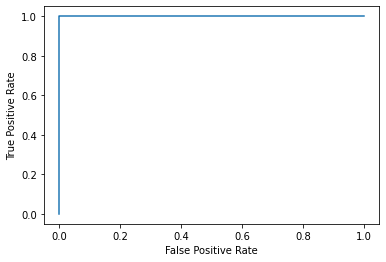

ROC curve of the test dataset . FOLD 1


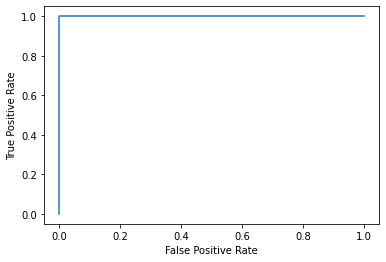

ROC curve of the train dataset . FOLD 2


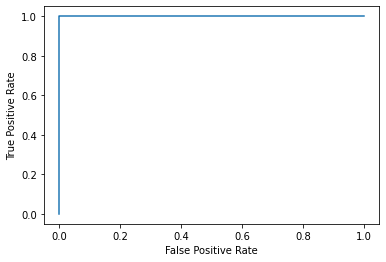

ROC curve of the test dataset . FOLD 2


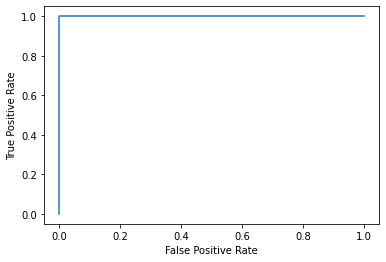

ROC curve of the train dataset . FOLD 3


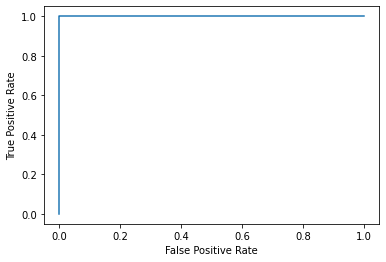

ROC curve of the test dataset . FOLD 3


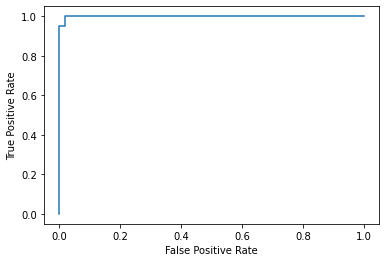

ROC curve of the train dataset . FOLD 4


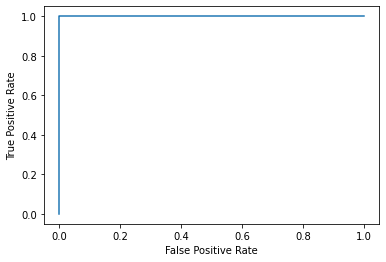

ROC curve of the test dataset . FOLD 4


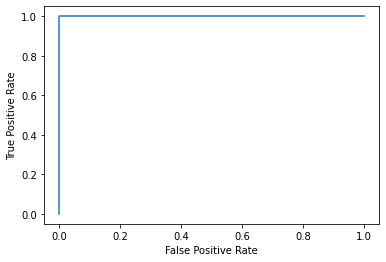

ROC curve of the train dataset . FOLD 5


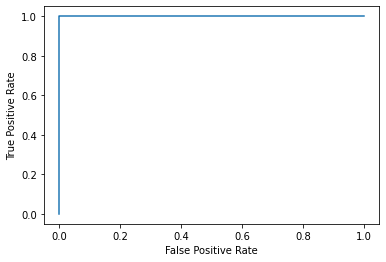

ROC curve of the test dataset . FOLD 5


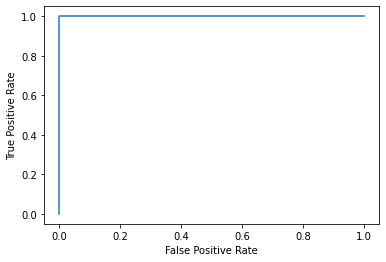

ROC curve of the train dataset . FOLD 6


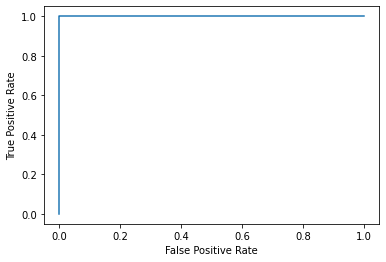

ROC curve of the test dataset . FOLD 6


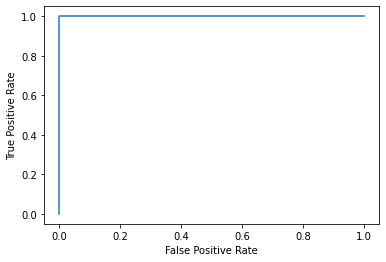

ROC curve of the train dataset . FOLD 7


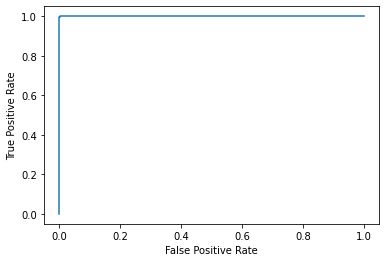

ROC curve of the test dataset . FOLD 7


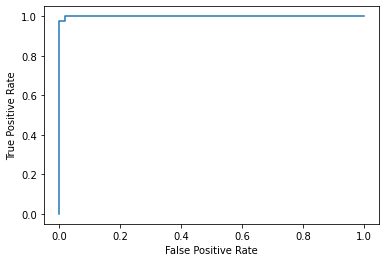

ROC curve of the train dataset . FOLD 8


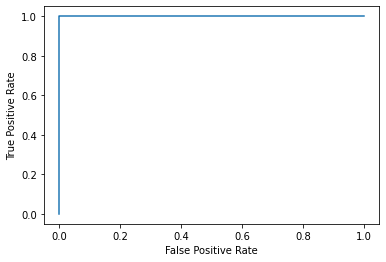

ROC curve of the test dataset . FOLD 8


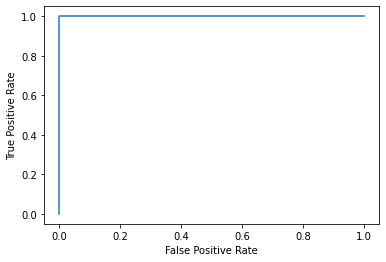


Performing of  Support Vector Machine(SVM)  algorithm with K-fold cross-validaiton on dataset in the audit_risk.csv

  Accuracy                          Precision              Recall
0  0.5154639175257731                 0.35                  0.4
1  0.5154639175257731                 0.3698630136986301                  0.36
2  0.5120274914089347                 0.3805309734513274                  0.3739130434782609
3  0.5025773195876289                 0.3698630136986301                  0.34838709677419355
4  0.49896907216494846                 0.3695652173913043                  0.3487179487179487
5  0.506872852233677                 0.38495575221238937                  0.3702127659574468
6  0.5110456553755522                 0.39245283018867927                  0.3781818181818182
7  0.5064432989690721                 0.38666666666666666                  0.3682539682539683

Average Accuracy: 0.5086079405989199
Average Precision: 0.3754871834134534
Average Recall: 0.36845833017045454

In [201]:
clasSVM=Reg_Clsfcn("audit_risk.csv",4)
clasSVM.SVM_class()
clasSVM.performanceOfModelcls("Support Vector Machine(SVM)")

# RESULT

SVM's main aim is the seperate data set by a hyperplane and then expand this hyperplane how much it can be expand. I have performed classifier based on linear SVM in this part. I have observed SVM 
could't classify data as good as KNN algorithm.after classificaiton I try to draw ROC curve. Bu I have
encounter a problem. while draw ROC curve for SVM , I need to find distance from data point to margin for each datapoint. Then I need to compare this distance beetween threshold and finaly I need to find rate of true positve (TP) and false positive(FP) . but probabilities that SVC modul give is not distance from margin . therefore I couldnt draw ROC curve correctly

# PART 4 (linear SVM regressor)

In [202]:
clasSVM=Reg_Clsfcn("day.csv",4)
clasSVM.SVM_reg()
clasSVM.performanceOfModelreg("Support Vector Machine(SVM)")

Mean Squared ERROR (MSE) for regressor based on linear SVM for FOLD 1 : 0.004085898465527878
Mean Squared ERROR (MSE) for regressor based on linear SVM for FOLD 2 : 0.004357104144798844
Mean Squared ERROR (MSE) for regressor based on linear SVM for FOLD 3 : 0.005020374860939895
Mean Squared ERROR (MSE) for regressor based on linear SVM for FOLD 4 : 0.00443182407791986
Mean Squared ERROR (MSE) for regressor based on linear SVM for FOLD 5 : 0.004361835100282169
Mean Squared ERROR (MSE) for regressor based on linear SVM for FOLD 6 : 0.005307175745454679
Mean Squared ERROR (MSE) for regressor based on linear SVM for FOLD 7 : 0.003474060696538193
Mean Squared ERROR (MSE) for regressor based on linear SVM for FOLD 8 : 0.004870718675827361
Mean Squared ERROR (MSE) for regressor based on linear SVM for FOLD 9 : 0.0032283527286625776
Mean Squared ERROR (MSE) for regressor based on linear SVM for FOLD 10 : 0.005409020657105727
Mean Squared ERROR (MSE) for regressor based on linear SVM for FOLD 1

# result

in this part I have performed regressor based on linear SVM. I have used to K-fold cross validation for seperate data for testing and training. After seperating data I have trained data and test them with test data. then I compute MSE(mean squared error ) for each fold. mean squared error show that 
regressor of SVM work god.

# 

# PART 5 (polynomial SVM classifier)

In [203]:
polySVM=Reg_Clsfcn("audit_risk.csv",4)
polySVM.SVM_pol()
polySVM.performanceOfModelcls("Support Vector Machine(SVM)")




Performing of  Support Vector Machine(SVM)  algorithm with K-fold cross-validaiton on dataset in the audit_risk.csv

  Accuracy                          Precision              Recall
0  0.6391752577319587                 0.5454545454545454                  0.16666666666666666
1  0.6391752577319587                 0.5238095238095238                  0.15492957746478872
2  0.6288659793814433                 0.47058823529411764                  0.1509433962264151
3  0.6417525773195877                 0.5227272727272727                  0.16312056737588654
4  0.6371134020618556                 0.5                  0.17613636363636365
5  0.6323024054982818                 0.4810126582278481                  0.18009478672985782
6  0.6391752577319587                 0.5053763440860215                  0.1910569105691057
7  0.6430412371134021                 0.5181818181818182                  0.20284697508896798

Average Accuracy: 0.6375751718213059
Average Precision: 0.5083937997226433
Aver

# RESULT


SVM model seperate data by hyperplane that can be linear or polynomial.sometimes data set can not seperate with linear hyperplane very good. when the dataset is like this svm model can use linear transformation and convert linear hyperplane and use polnomial SVM. by this method classificaiton can give more good accurancy than linar SVM

# PART 6 ( classifier based on DT(Decision Trees))


In [204]:
DT_class=Reg_Clsfcn("audit_risk.csv",4)
DT_class.DT_classifier(True)
DT_class.performanceOfModelcls("DECISION TREE(DT))")
DT_class.rules_of_DT()


Performing of  DECISION TREE(DT))  algorithm with K-fold cross-validaiton on dataset in the audit_risk.csv

  Accuracy                          Precision              Recall
0  0.5773195876288659                 0.36666666666666664                  0.3333333333333333
1  0.5773195876288659                 0.3492063492063492                  0.3492063492063492
2  0.5773195876288659                 0.3557692307692308                  0.3978494623655914
3  0.5747422680412371                 0.35                  0.3983739837398374
4  0.5711340206185567                 0.3463687150837989                  0.40522875816993464
5  0.5773195876288659                 0.3548387096774194                  0.4207650273224044
6  0.5743740795287187                 0.35271317829457366                  0.4272300469483568
7  0.5644329896907216                 0.3442622950819672                  0.43209876543209874

Average Accuracy: 0.5742452135493372
Average Precision: 0.3524781430975007
Average Recall:

In [205]:
DT_class=Reg_Clsfcn("audit_risk.csv",4)
DT_class.DT_classifier(False)
DT_class.performanceOfModelcls("DECISION TREE(DT))")
DT_class.rules_of_DT()


Performing of  DECISION TREE(DT))  algorithm with K-fold cross-validaiton on dataset in the audit_risk.csv

  Accuracy                          Precision              Recall
0  0.5876288659793815                 0.5151515151515151                  0.4146341463414634
1  0.5876288659793815                 0.4594594594594595                  0.4594594594594595
2  0.570446735395189                 0.41509433962264153                  0.411214953271028
3  0.5463917525773195                 0.3732394366197183                  0.37857142857142856
4  0.5381443298969072                 0.3621621621621622                  0.3872832369942196
5  0.5292096219931272                 0.34684684684684686                  0.3737864077669903
6  0.5272459499263623                 0.3458646616541353                  0.38493723849372385
7  0.5244845360824743                 0.34098360655737703                  0.38235294117647056

Average Accuracy: 0.5513975822287678
Average Precision: 0.394850253509232
Av


# result

decision tree dont use all features for classificaiton . our model use  one feture for classifaciton . therefore ıt's accuracy is too low

# PART 7(Regressor based on DT)

In [206]:
regDT=Reg_Clsfcn("day.csv",4)
clasSVM.DT_regressor(False)
clasSVM.performanceOfModelreg("Support Vector Machine(SVM)")

Mean Squared ERROR (MSE) for regressor based on DT for FOLD 1 : 185783.0
Mean Squared ERROR (MSE) for regressor based on DT for FOLD 2 : 521649.70588235295
Mean Squared ERROR (MSE) for regressor based on DT for FOLD 3 : 552283.1764705882
Mean Squared ERROR (MSE) for regressor based on DT for FOLD 4 : 562022.8823529412
Mean Squared ERROR (MSE) for regressor based on DT for FOLD 5 : 1745030.5882352942
Mean Squared ERROR (MSE) for regressor based on DT for FOLD 6 : 518981.5294117647
Mean Squared ERROR (MSE) for regressor based on DT for FOLD 7 : 2183786.2352941176
Mean Squared ERROR (MSE) for regressor based on DT for FOLD 8 : 1208798.705882353
Mean Squared ERROR (MSE) for regressor based on DT for FOLD 9 : 858615.8235294118
Mean Squared ERROR (MSE) for regressor based on DT for FOLD 10 : 1299179.1176470588
Mean Squared ERROR (MSE) for regressor based on DT for FOLD 11 : 1210701.0
Mean Squared ERROR (MSE) for regressor based on DT for FOLD 12 : 336037.76470588235
Mean Squared ERROR (MSE) 

# result


in this model we get too high mse. for me this algorithm overfitted